# Week 5: Molecular Dynamics

## Exercise 24

### 4.1 1D Harmonic oscillator

Demonstrating that a molecular dynamics approach with a thermostat results in the same thermal ensemble of position observations as did the Metropolis MC approach.

### 4.2 Metropolis Monte Carlo sampling

Repeat your Metropolis Monte Carlo sampling of the position of the harmonic oscillator, (𝑚=1,𝜔=1), at some different temperatures. Establish the thermal average of the potential energy at 𝑘𝐵_𝑇=0.15.

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import builtins

# Constants
m = 1
omega = 1 
k = m * omega ** 2  # spring constant
kT_values = [0.05, 0.15, 0.25, 0.35]  # Different values for kT

x_min = -3
x_max = 3
x_points = 400

bin_number = 50

# Potential energy function based on harmonic potential
def V(x, k, x0):
    return 0.5 * k * (x - x0) ** 2

# Metropolis sampling function
def metropolis_sampling(x0, N, Delta, kT):
    samples = []
    current_x = x0
    for _ in builtins.range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Acceptance probability (min(1, P(x') / P(x)))
        acceptance_prob = min(1, np.exp(-(V(proposed_x, k, x0) - V(current_x, k, x0)) / kT))

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)

    return np.array(samples)

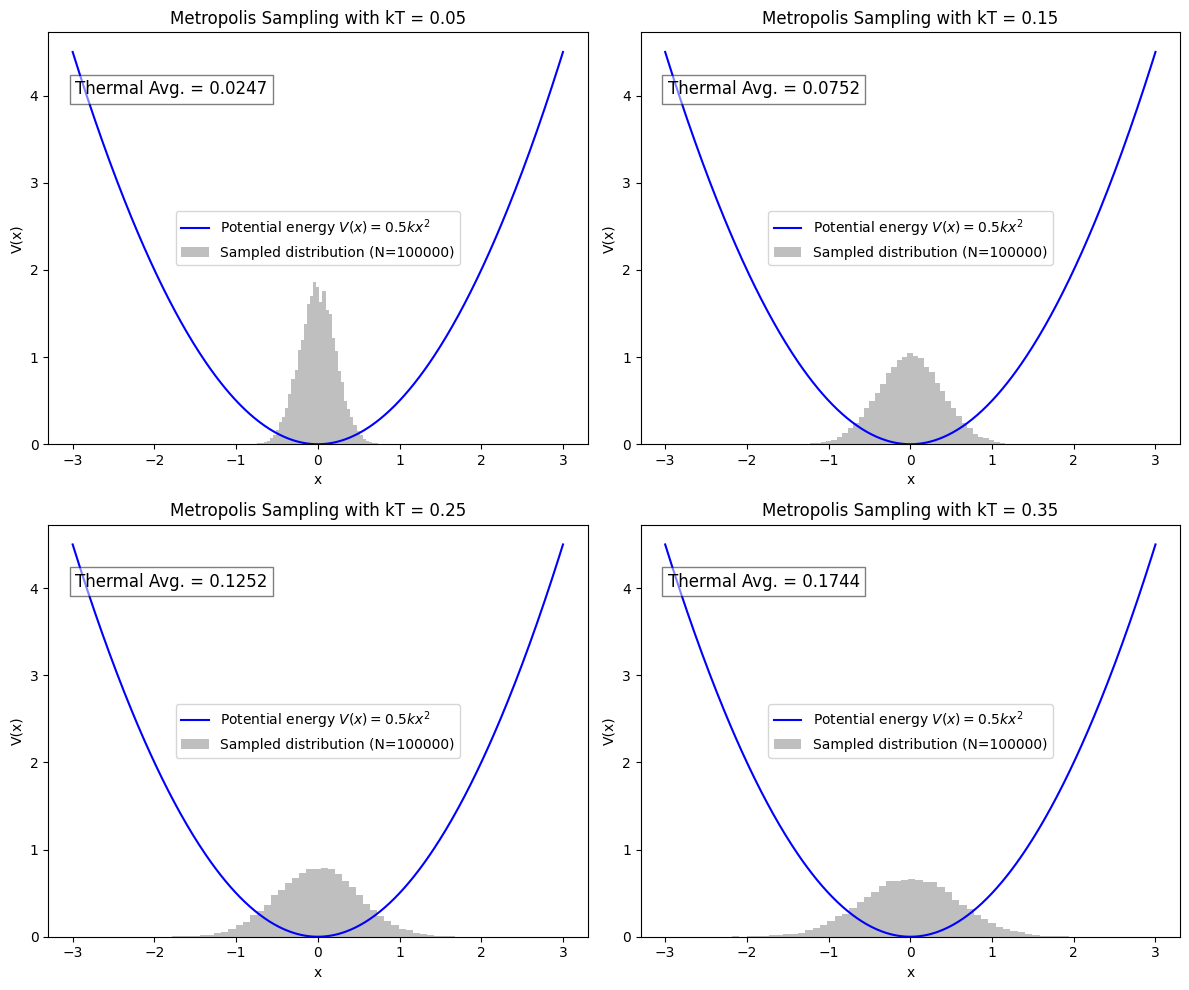

In [115]:
# Initial position and parameters for sampling
x0 = 0.0
N = 100000
Delta = 1

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) 
axs = axs.flatten() 

for i, kT in enumerate(kT_values):
    xs = np.linspace(x_min, x_max, x_points)
    samples = metropolis_sampling(x0, N, Delta, kT)
    
    # get Epot = ½kx² iot calc thermal_average
    potential_energies = V(samples, k, x0) # V def in above cell
    # thermal_average is mean of Epot:
    thermal_average = np.mean(potential_energies)
    
    axs[i].plot(xs, V(xs, k, x0), label="Potential energy $V(x) = 0.5kx^2$", color="blue")
    axs[i].hist(samples, bins=bin_number, density=True, alpha=0.5, color='gray', label=f"Sampled distribution (N={N})")
    axs[i].text(0.05, 0.85, f'Thermal Avg. = {thermal_average:.4f}', transform=axs[i].transAxes,
                fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('V(x)')
    axs[i].set_title(f'Metropolis Sampling with kT = {kT}')
    axs[i].legend()

plt.tight_layout()
plt.show()

### 4.3 Constant energy MD (NVE)

Implement velocity Verlet algo. Delta_t=0.01 plot positions as fct of t. Also, plot distribution of positions observed at regular time intervals.

/tmp/ipykernel_1164154/3480852628.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


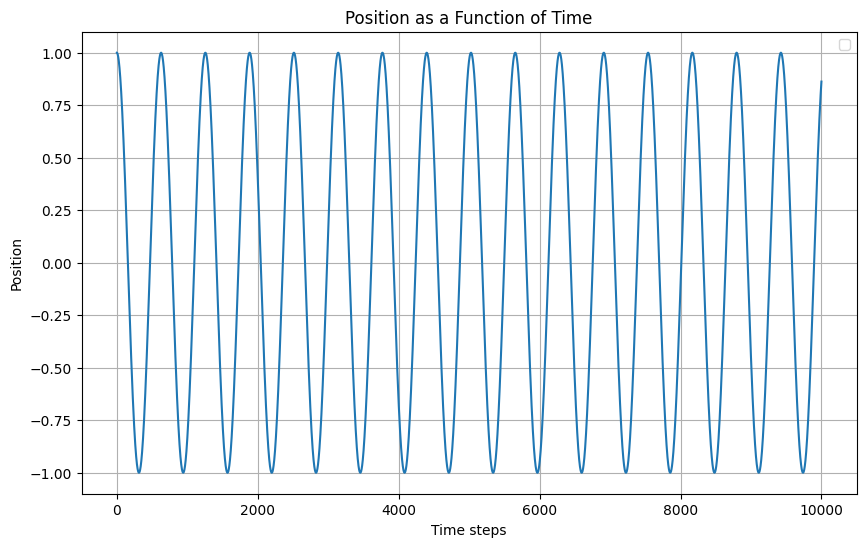

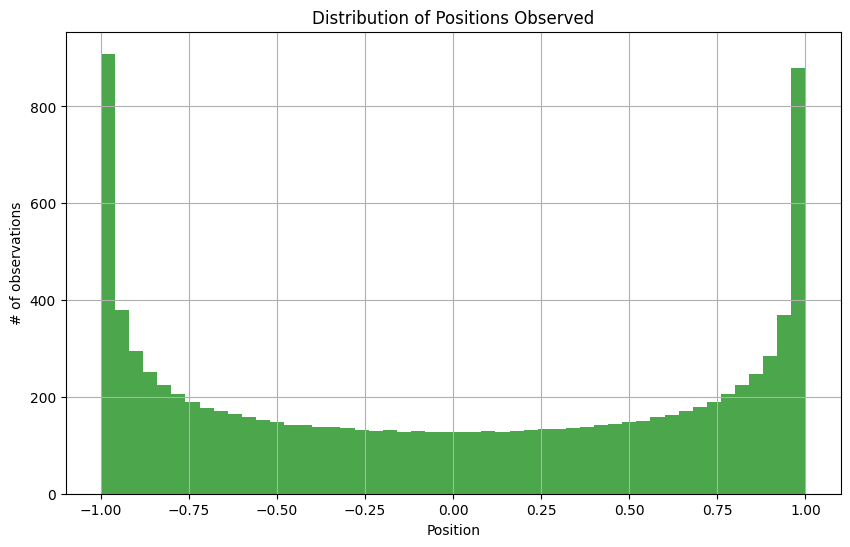

In [116]:
# Constants
Delta_t = 0.01  # time step
time_steps = 10000  # total number of time steps

# Harmonic potential function
def V(x, k):
    return 0.5 * k * x ** 2

# Force as the derivative of the potential: F = -dV/dx = -k * x
def force(x, k):
    return -k * x

def velocity_verlet(x0, v0, k, m, Delta_t, time_steps, adjustment_interval = 0, sigma = 0):
    positions = []
    velocities = []
    times = np.arange(0, time_steps * Delta_t, Delta_t)  # time array
    x = x0
    v = v0
    a = force(x, k) / m  # initial acceleration

    for t in times:
        # Update position
        x = x + v * Delta_t + 0.5 * a * Delta_t ** 2
        positions.append(x)

        # Calculate new acceleration
        a_new = force(x, k) / m

        # Update velocity
        v = v + 0.5 * (a + a_new) * Delta_t
        velocities.append(v)

        # Update acceleration for next step
        a = a_new

        if (sigma!=0):
            # Adjust velocities every `adjustment_interval` steps
            if (step + 1) % adjustment_interval == 0:
                v = np.random.normal(0, sigma)  # Draw a new velocity from N(0, sigma^2)

    return np.array(positions), np.array(velocities), times / Delta_t

x0 = 1.0  # initial x
v0 = 0.0  # initial v

# Run simulation
positions, velocities, times = velocity_verlet(x0, v0, k, m, Delta_t, time_steps)

# Plot 1: Position as a function of time steps
plt.figure(figsize=(10, 6))
plt.plot(times, positions)
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Distribution of positions observed at regular intervals
plt.figure(figsize=(10, 6))
plt.hist(positions, bins=50, alpha=0.7, color='g')
plt.xlabel('Position')
plt.ylabel('# of observations')
plt.title('Distribution of Positions Observed')
plt.grid(True)
plt.show()


### 4.4 Constant temperature MD (NVT). 

I.e. draw random velocity from $N(0,\sigma^2)$ where $\sigma=\sqrt{kT/m}.$

Run the MD simulation for 50 timesteps after each velocity adjustment, and sample the positions at the end of these timesteps.

Evaluate the thermal average, $\langle V_{pot}\rangle$, of the potential energy and estimate the heat capacity in units of $k_B$, $C_v/k_B$, via the observed fluctuations in the potential energy.

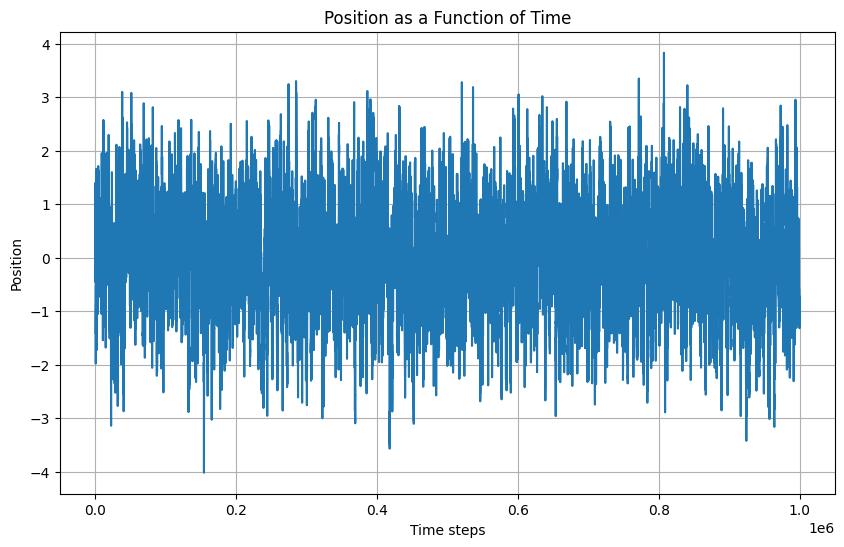

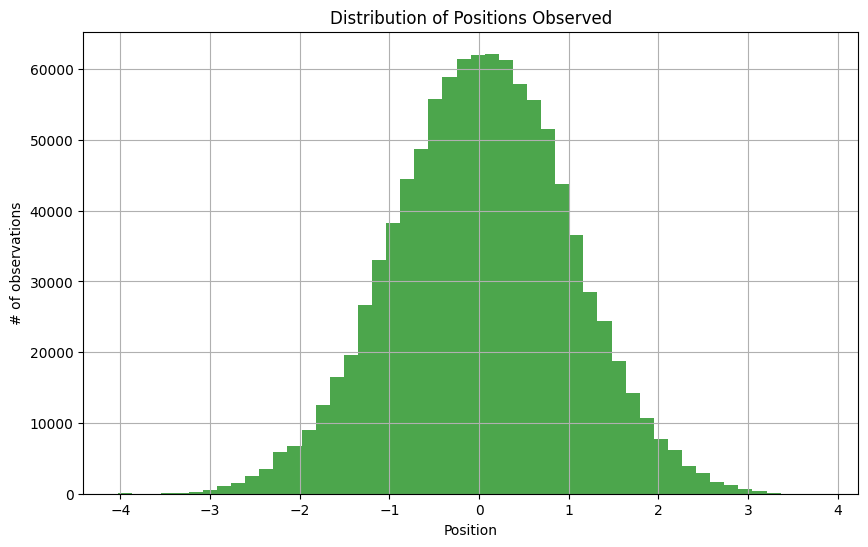

In [117]:
# Constants
Delta_t = 0.01  # time step
time_steps = 1000000  # total number of time steps

# Harmonic potential function
def V(x, k):
    return 0.5 * k * x ** 2

def force(x, k):
    return -k * x

def velocity_verlet(x0, v0, k, m, Delta_t, time_steps, adjustment_interval=0, sigma=0):
    positions = []
    velocities = []
    potential_energies = []
    thermostat_actions = []  
    times = np.arange(0, time_steps * Delta_t, Delta_t)
    x = x0
    v = v0
    a = force(x, k) / m 

    for step in range(time_steps):
        x = x + v * Delta_t + 0.5 * a * Delta_t ** 2
        positions.append(x)

        a_new = force(x, k) / m

        v = v + 0.5 * (a + a_new) * Delta_t
        velocities.append(v)

        a = a_new

        potential_energies.append(V(x, k))

        if sigma != 0 and (step + 1) % adjustment_interval == 0:
            v = np.random.normal(0, sigma)
            thermostat_actions.append(step + 1)

    return np.array(positions), np.array(velocities), np.array(potential_energies), np.array(thermostat_actions), np.arange(time_steps)

x0 = 1.0
v0 = 0.0
k = 1.0
m = 1.0
sigma = 1.0
adjustment_interval = 50

# Run simulation with thermostat
positions, velocities, potential_energies, thermostat_actions, times = velocity_verlet(
    x0, v0, k, m, Delta_t, time_steps, adjustment_interval, sigma
)

# Plot 1: Position as a function of time steps
plt.figure(figsize=(10, 6))
plt.plot(times, positions)
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.show()

# Plot 2: Distribution of positions observed at regular intervals
plt.figure(figsize=(10, 6))
plt.hist(positions, bins=50, alpha=0.7, color='g')
plt.xlabel('Position')
plt.ylabel('# of observations')
plt.title('Distribution of Positions Observed')
plt.grid(True)
plt.show()


## Exercise 25 

### 5.1 1D Double well 

1d pot with two energy minima is considered with molecular dynamics. Demonstating that thermal samples can be established. (Trapping in the local minimum at low temps may be an issue).

### 5.2 The potential
A potential is given. 

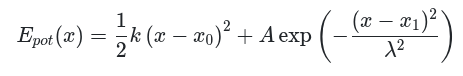

Plot it. 

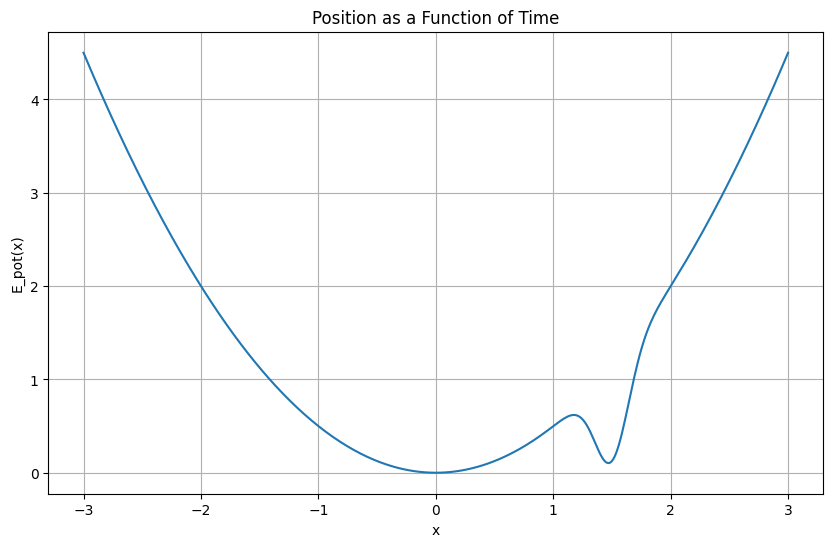

In [118]:
# Constants (chosen to match image in exercise)
lamb = 0.2
x0 = 0.0
x1 = 1.5
A = -1
k = 1.0

# Potential function
def E_pot(x, k, A, x1, lamb, x0):
    return 0.5 * k * (x - x0)**2 + A * np.exp(-((x - x1)**2) / lamb**2)

x = np.linspace(x_min, x_max, x_points)

y = E_pot(x, k, A, x1, lamb, x0)
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('E_pot(x)')
plt.title('Position as a Function of Time')
plt.grid(True)
plt.show()


b) Evaluate analytically the force and implement it. Plot ontop of the potential energy plot, the integrated (negative) force:

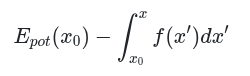

In [119]:
from scipy.integrate import quad


def force2(x, k, A, x1, lamb,  x0):
    force = -k * (x - x0) + A * (2 * (x - x1) / lamb**2) * np.exp(-((x - x1)**2) / lamb**2)
    return force

#and use to compare with the integrated negative force
def int_neg_force(x):
    integral_of_force, _ = quad(force2, x0, x, args=(k, A, x1, lamb, x0))
    y = E_pot(x0, k, A, x1, lamb,  x0) - integral_of_force
    return y

print(int_neg_force(-1))

0.5


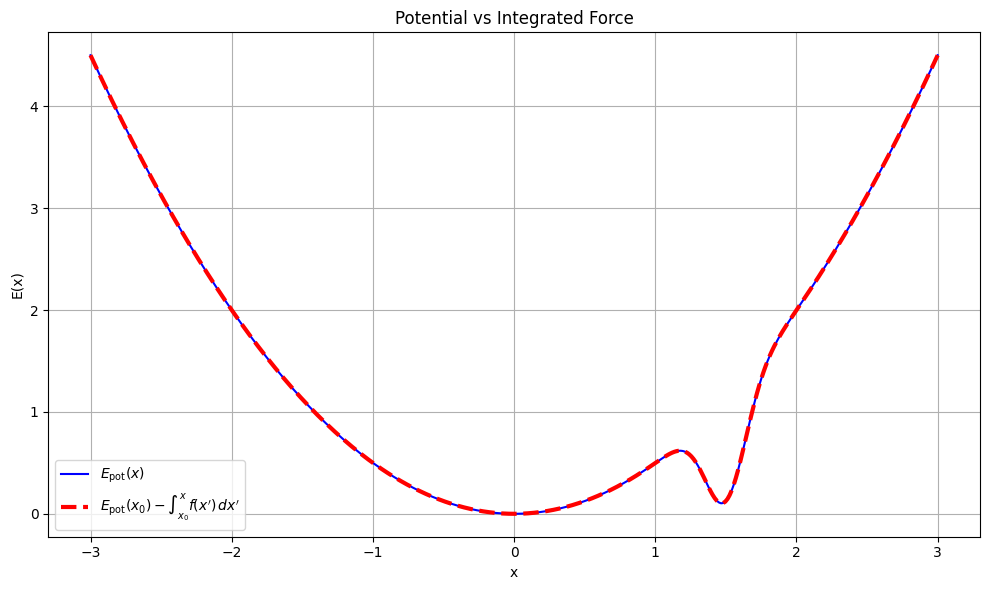

In [120]:
xs = np.linspace(-3, 3, 400)
ys_pot = E_pot(xs, k, A, x1, lamb,  x0)
ys_integrated = np.array([int_neg_force(x) for x in xs])

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(xs, ys_pot, label=r'$E_{\mathrm{pot}}(x)$', color='blue')
plt.plot(xs, ys_integrated, '--', linewidth=3, label=r'$E_{\mathrm{pot}}(x_0) - \int_{x_0}^{x} f(x^\prime)\,dx^\prime$', color='red')
plt.xlabel('x')
plt.ylabel('E(x)')
plt.title('Potential vs Integrated Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.3 Metropolis MC

Direct integration and Metropolis MC estimation of the thermally averaged potential energy of this oscillator. 
Plot the distribution prob fct, and repeat for some different temps.

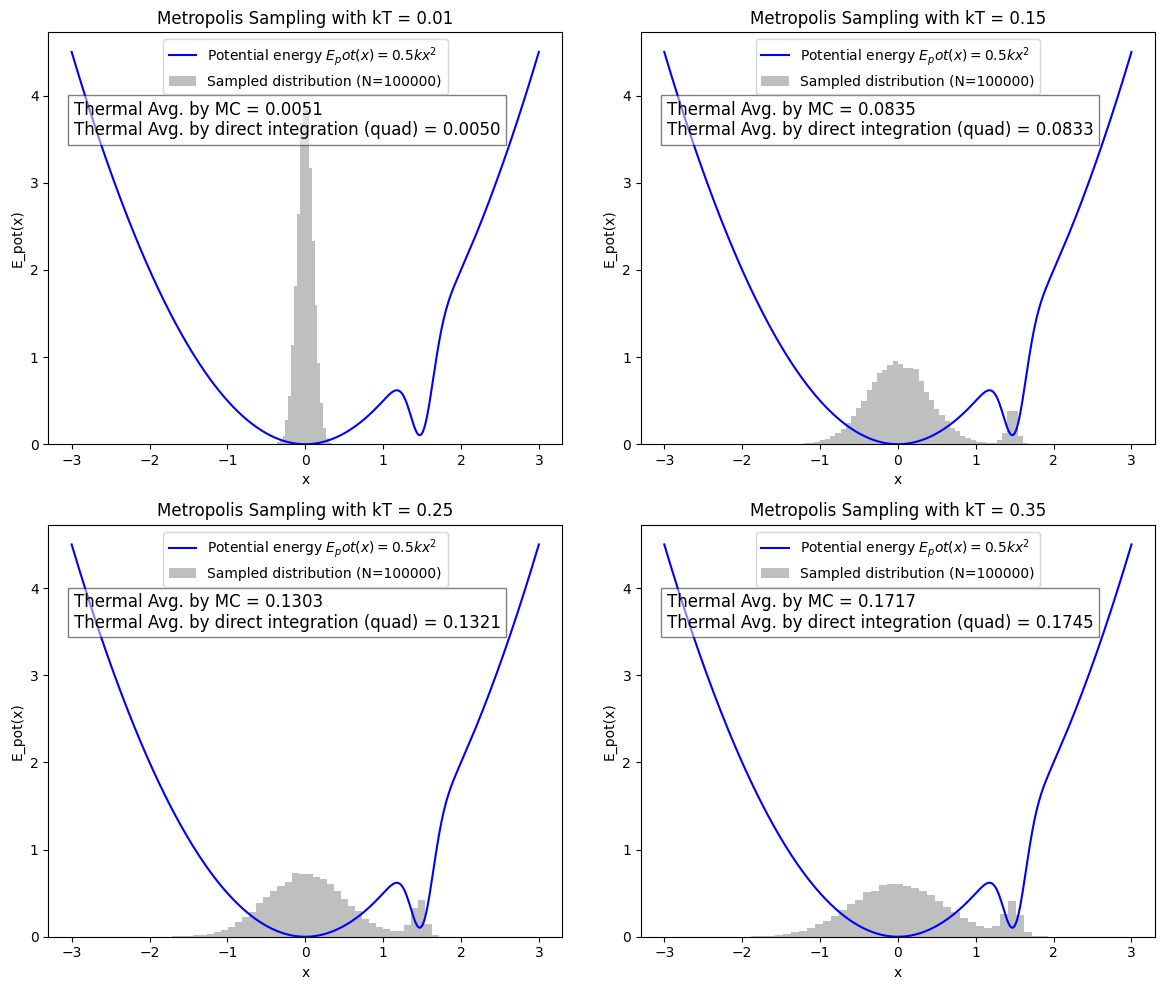

First few samples for kT=0.35: [ 0.04555912  0.04555912  0.04555912  0.33610186 -0.39484857]


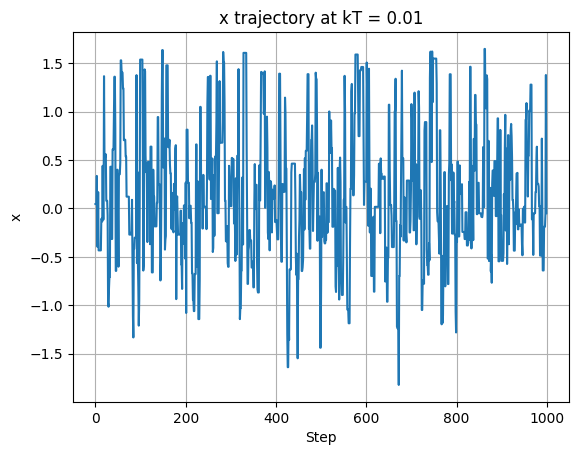

In [121]:
# Constants
m = 1
omega = 1 
k = m * omega ** 2
kT_values = [0.01, 0.15, 0.25, 0.35] 
x_min = -3
x_max = 3
x_points = 400
bin_number = 50
x0 = 0.0
N = 100000
Delta = 1

def metropolis_sampling(start_x, N, Delta, kT):
    samples = []
    current_x = start_x
    for _ in builtins.range(N):
        RNDn = np.random.randn()
        # step 1: propose a new pos
        proposed_x = current_x + Delta * RNDn
        # step 2: accept/reject pos based on Boltzmann probability
        acceptance_prob = min(1, np.exp(-(E_pot(proposed_x, k, A, x1, lamb,  x0) - E_pot(current_x, k, A, x1, lamb,  x0)) / kT))
        # step 3: if accepted, move to proposed_x
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x 
        # step 4: append current_x to list of samples
        samples.append(current_x)

    return np.array(samples)

def boltzmann_average(kT):
    # Numerator
    num = quad(lambda x: E_pot(x, k, A, x1, lamb,  x0) * np.exp(-E_pot(x, k, A, x1, lamb,  x0)/kT), x_min, x_max)[0]
    # Denominator
    denom = quad(lambda x: np.exp(-E_pot(x, k, A, x1, lamb,  x0)/kT), x_min, x_max)[0]
    return num / denom

fig, axs = plt.subplots(2, 2, figsize=(12, 10)) 
axs = axs.flatten() 

for i, kT in enumerate(kT_values):
    xs = np.linspace(x_min, x_max, x_points)
    samples = metropolis_sampling(1.5, N, Delta, kT)
    
    potential_energies = E_pot(samples, k, A, x1, lamb,  x0)
    
    thermal_average_mc = np.mean(potential_energies)
    thermal_average_direct = boltzmann_average(kT)
    
    axs[i].plot(xs, E_pot(xs, k, A, x1, lamb,  x0), label="Potential energy $E_pot(x) = 0.5kx^2$", color="blue")
    
    axs[i].hist(samples, bins=bin_number, density=True, alpha=0.5, color='gray', label=f"Sampled distribution (N={N})")

    axs[i].text(0.05, 0.75, 
            f'Thermal Avg. by MC = {thermal_average_mc:.4f}\n'
            f'Thermal Avg. by direct integration (quad) = {thermal_average_direct:.4f}', 
            transform=axs[i].transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('E_pot(x)')
    axs[i].set_title(f'Metropolis Sampling with kT = {kT}')
    axs[i].legend()

plt.tight_layout()
plt.show() 

print(f"First few samples for kT={kT}: {samples[:5]}")

plt.plot(samples[:1000])
plt.title("x trajectory at kT = 0.01")
plt.xlabel("Step")
plt.ylabel("x")
plt.grid(True)
plt.show()



### 5.4 Molecular dynamics

c) Do sampling with MD. Start osc at x = x0. Perform 50 velocity Verlet steps with Delta_t = 0.01 after each thermalization step. Let sample be composed of the end-points of 10,000 such 50-step runs.

In [150]:
# --- Constants ---

# oscillator constants
m = 1
omega = 1 
k = m * omega ** 2

#plotting parameters
x_min = -3
x_max = 3
x_points = 400
bin_number = 50

#simulation constants
N_runs = 10000  # number of runs
Delta_t = 0.05  # smaller time step for finer exploration
time_steps = 200  # number of steps per run

# parameters controlling the potential energy function
lamb = 0.2
x0 = 0.0
x1 = 1.5  # position of second potential well
A = -1  # depth of the potential well
v0 = 0.0  # initial velocity



In [151]:
class MolecularDynamics:
    def __init__(self, pos, filter_mask):
        """Initialize with positions and a filter for fixed particles."""
        self.pos = pos  # Positions of particles
        self.filter = filter_mask  # Boolean mask indicating fixed particles
        self.velocities = np.zeros(self.pos.shape)  # Initialize velocities to zero
    
    @property
    def kinetic_energy(self):
        """Calculate the kinetic energy."""
        return 0.5 * np.sum(self.velocities**2)

    def set_velocities(self, velocities):
        """Set velocities, zeroing out those that are fixed."""
        self.velocities = np.where(self.filter, 0, velocities)

    def get_velocities(self):
        """Return a copy of the velocities to prevent modification."""
        return self.velocities.copy()

    def velocity_verlet_step(self, x, v, a, Delta_t):
        """Perform one step of the Velocity Verlet algorithm."""
        x_new = x + v * Delta_t + 0.5 * a * Delta_t ** 2
        return x_new

    def update_velocity(self, v, a, a_new, Delta_t):
        """Update the velocity in the Velocity Verlet algorithm."""
        v_new = v + 0.5 * (a + a_new) * Delta_t
        return v_new

    def molecular_dynamics_sampling(self, x_start, k, m, Delta_t, time_steps, N_runs, sigma):
        """Run the velocity Verlet algorithm and return sampled endpoints."""
        samples = []

        for run in range(N_runs):
            x = x_start
            v = np.random.normal(0, sigma, size=self.pos.shape)  # Initial velocity
            self.set_velocities(v)  # Use the set method to initialize velocities
            a = force2(x, k, A, x1, lamb, x0) / m  # Initial acceleration

            for step in range(time_steps):
                # Perform one velocity Verlet step
                x_new = self.velocity_verlet_step(x, v, a, Delta_t)
                a_new = force2(x_new, k, A, x1, lamb, x0) / m  # New acceleration
                v_new = self.update_velocity(v, a, a_new, Delta_t)

                # Update positions and velocities
                x, v, a = x_new, v_new, a_new
                self.set_velocities(v)  # Apply the filter after each update

            # Store the final position
            samples.append(x)

        print(f"Mean Kinetic Energy after sampling: {self.kinetic_energy:.4f}")
        return np.array(samples)


Mean Kinetic Energy after sampling: 0.0376
Mean Kinetic Energy after sampling: 0.0234
Mean Kinetic Energy after sampling: 0.0305
Mean Kinetic Energy after sampling: 0.4485


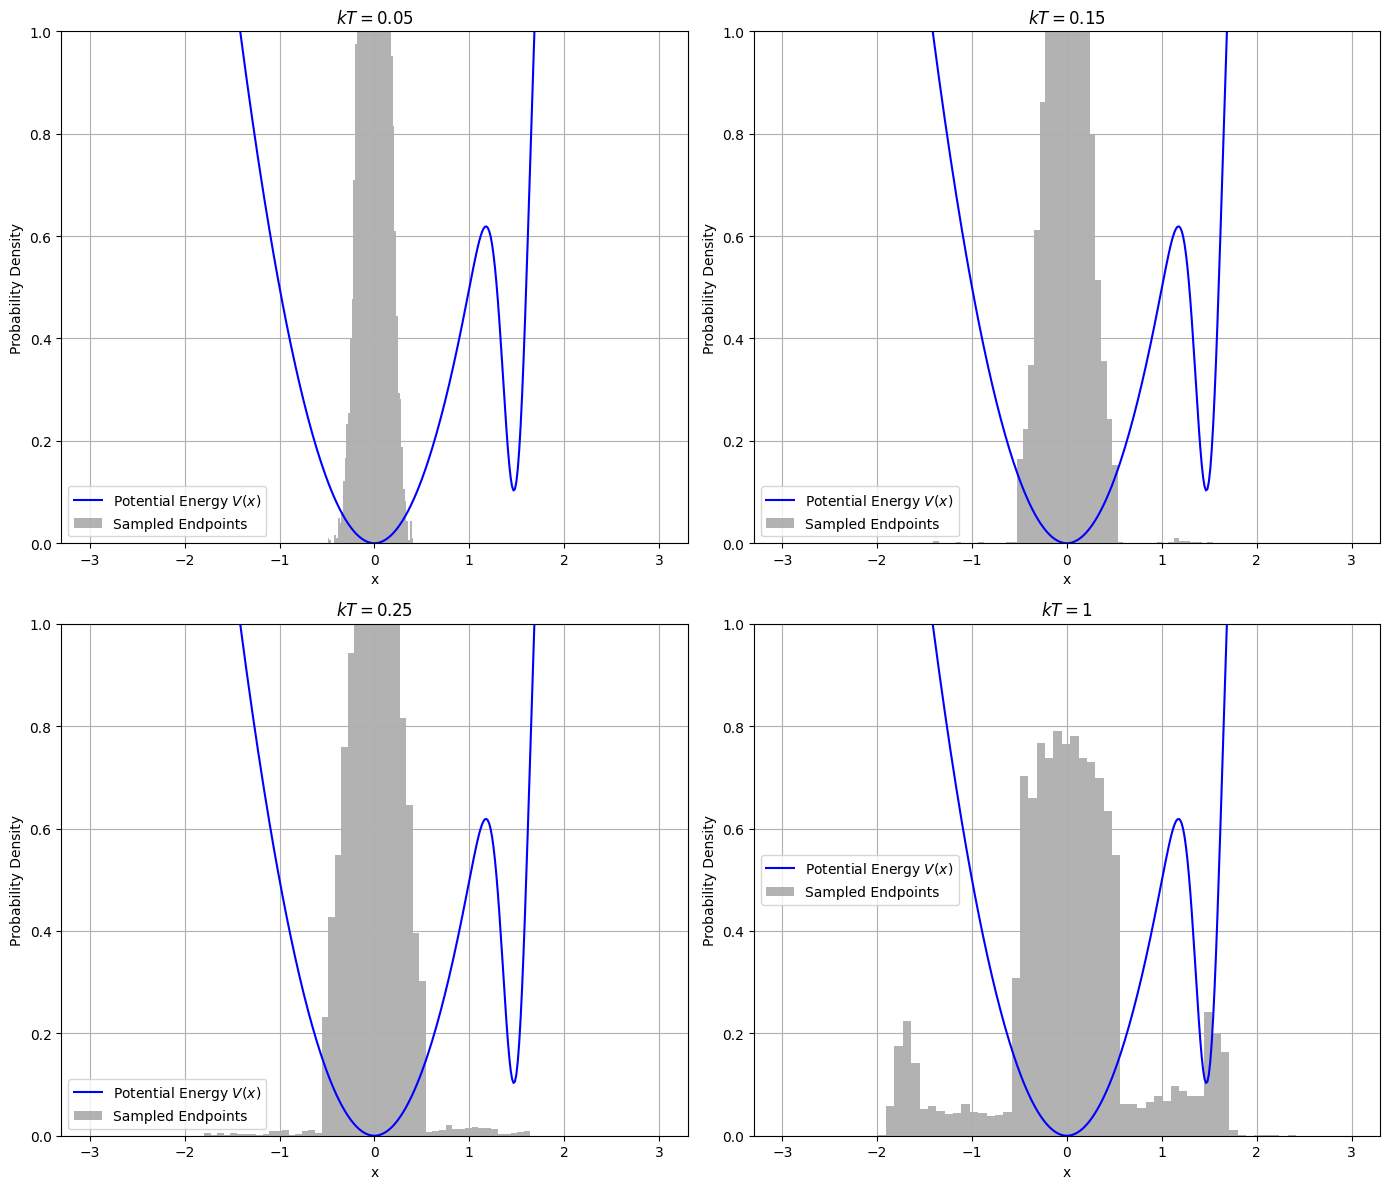

In [153]:
# Define initial positions (can be zeros or random)
positions = np.zeros((1,))  # Placeholder for single-particle or multi-dimensional
filter_mask = np.array([False])  # No fixed particles initially

# Create an instance of the MolecularDynamics class
md_sim = MolecularDynamics(positions, filter_mask)

# Temperature values to test
kT_values = [0.05, 0.15, 0.25, 1]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, kT in enumerate(kT_values):
    sigma = np.sqrt(kT / m)  # Calculate velocity dispersion
    # Use the class method for MD sampling
    samples = md_sim.molecular_dynamics_sampling(x0, k, m, Delta_t, time_steps, N_runs, sigma)
    
    # Plot the results
    ax = axes[i // 2, i % 2]
    plot_results(samples, x_min, x_max, x_points, k, A, x1, lamb, kT, ax)

plt.tight_layout()
plt.show()


d) Repeat c) but starting at x=x1.

Start at x = 1.5 -> Well Visits: {'first_well': 0, 'second_well': 10000}
Start at x = 1.5 -> Well Visits: {'first_well': 23, 'second_well': 9977}
Start at x = 1.5 -> Well Visits: {'first_well': 114, 'second_well': 9886}
Start at x = 1.5 -> Well Visits: {'first_well': 1288, 'second_well': 8712}


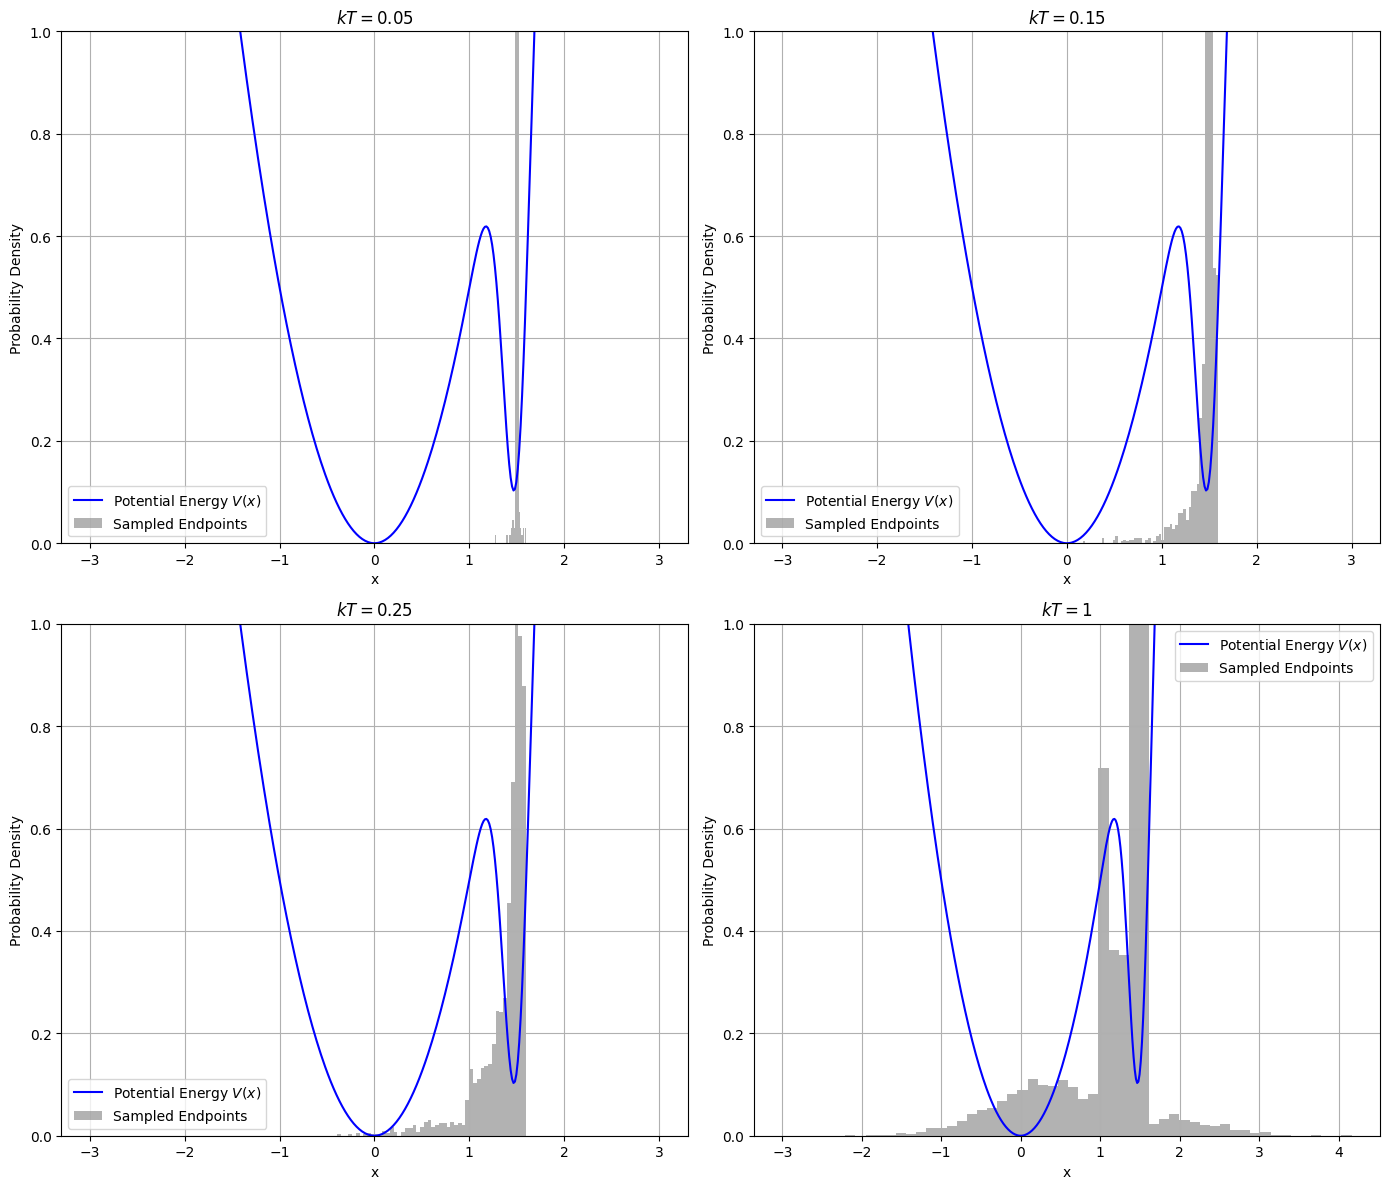

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, kT in enumerate(kT_values):
    sigma = np.sqrt(kT / m)
    samples = molecular_dynamics_sampling(x1, v0, k, m, Delta_t, time_steps, N_runs, sigma)
    
    ax = axes[i // 2, i % 2]
    plot_results(samples, x_min, x_max, x_points, k, A, x1, lamb, kT, ax)

plt.tight_layout()
plt.show()

COMMENTS:

This is not entirely what I expected from the behavior. To some extent it does explore both wells if the temperature is high enough, but I cannot get it to look like Bjork's figure. I have tried running the simulation for longer, adjusting number of time steps, adjusting Delta t.

## Exercise 26

### 6.1 Constant Energy MD in 4D

In this exercise, we shall perform molecular dynamics for Lennard-Jones atoms.

(I have extended the previous class to describe atomic clusters with attributes and methods to cover velocities and kinetic energy).

### 6.2 Relaxation

Decide on a structure with some static atoms and two dynamic atoms. Set it up and perform a relaxation of the two dynamic atoms so that you get to know their equilibrium positions.

A bunch of classes from w3 (yeah, I know I should just import them :|)

In [183]:
class ClusterOptimizer:
    def __init__(self, potential, num_movable, tolerance=1e-5, max_iters=2000):
        """
        Initialize the ClusterOptimizer.

        Args:
            potential: Lennard-Jones potential object with `energy` and `forces` methods.
            num_movable: Number of movable atoms in the cluster.
            tolerance: Convergence criterion for the force magnitude.
            max_iters: Maximum number of iterations for the optimization.
        """
        self.potential = potential
        self.num_movable = num_movable
        self.tolerance = tolerance
        self.max_iters = max_iters

    def initialize_positions(self, fixed_atom, r_min):
        """
        Initialize positions for movable atoms with a minimum distance constraint.

        Args:
            fixed_atom: Position of the fixed atom as a (1, 2) array.
            r_min: Minimum allowed distance between atoms.

        Returns:
            Movable atom positions as a (num_movable, 2) array.
        """
        positions = []
        while len(positions) < self.num_movable:
            candidate = np.random.uniform(-2, 2, size=(1, 2))
            distances = np.linalg.norm(candidate - fixed_atom, axis=1)
            if np.all(distances >= r_min):
                positions.append(candidate[0])
        return np.array(positions)

    def run_optimization(self):
        """
        Perform the optimization process.

        Returns:
            fixed_atoms, movable_atoms, final_positions
        """
        fixed_atoms = [
            [0.0, 0.0],
            [1.0, 0.0],
            [2.0, 0.0],
            [-1.0, 0.0],
            [-2.0, 0.0],
            ]
        movable_atoms = np.array([
            [1.0, 1.5],
            [-1.0, 1.5],
        ])
        initial_cluster = np.vstack((fixed_atoms, movable_atoms))
        print("Initial Atomic Cluster:")
        print(initial_cluster)

        line_search = LineSearchMultiMovable(
            potential=self.potential,
            fixed_atoms=fixed_atoms,
            movable_atoms=movable_atoms,
            tolerance=self.tolerance,
            max_iters=self.max_iters,
        )
        line_search.run()

        _, final_positions = line_search.get_results()

        print("\nFinal Atomic Cluster:")
        print(final_positions)

        return np.array(fixed_atoms), movable_atoms.copy(), final_positions

import matplotlib.pyplot as plt
import numpy as np

class AtomicClusterPlotter:
    def __init__(self, potential, fixed_atoms, movable_atoms, final_positions):
        """
        Initialize the AtomicClusterPlotter.

        Args:
            potential: The Lennard-Jones potential object with an `energy` method.
            fixed_atoms: Positions of fixed atoms as a (n, 2) array.
            movable_atoms: Initial positions of movable atoms as a (m, 2) array.
            final_positions: Final positions of all atoms (fixed + movable) as a (n+m, 2) array.
        """
        self.potential = potential
        self.fixed_atoms = np.array(fixed_atoms)
        self.movable_atoms = np.array(movable_atoms)
        self.final_positions = np.array(final_positions)

    def plot_init_final(self):
        """Plot the initial and final configurations."""
        plt.figure(figsize=(10, 5))

        # Initial configuration
        plt.subplot(1, 2, 1)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.fixed_atoms[:, 0],
            self.fixed_atoms[:, 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.movable_atoms[:, 0],
            self.movable_atoms[:, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        initial_energy = self.potential.energy(np.vstack((self.fixed_atoms, self.movable_atoms)))
        plt.title(f"Initial Configuration\nE = {initial_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        # Final configuration
        plt.subplot(1, 2, 2)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.final_positions[:len(self.fixed_atoms), 0],
            self.final_positions[:len(self.fixed_atoms), 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.final_positions[len(self.fixed_atoms):, 0],
            self.final_positions[len(self.fixed_atoms):, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        final_energy = self.potential.energy(self.final_positions)
        plt.title(f"Optimized Configuration\nE = {final_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
    
    def plot_only_one_config(self):
        """Plot just one config"""
        plt.figure(figsize=(10, 5))

        # Configuration
        plt.subplot(1, 1, 1)
        plt.gca().set_aspect('equal')
        plt.scatter(
            self.final_positions[:len(self.fixed_atoms), 0],
            self.final_positions[:len(self.fixed_atoms), 1],
            color="blue",
            s=1200,
            label="Fixed Atoms",
        )
        plt.scatter(
            self.final_positions[len(self.fixed_atoms):, 0],
            self.final_positions[len(self.fixed_atoms):, 1],
            color="red",
            s=1200,
            label="Movable Atoms",
        )
        final_energy = self.potential.energy(self.final_positions)
        plt.title(f"Optimized Configuration\nE = {final_energy:.3f}")
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

from scipy.spatial.distance import pdist

class LennardJones:
    def __init__(self, eps0=5, sigma=2**(-1/6), r_min=0.89):
        self.eps0 = eps0
        self.sigma = sigma
        self.r_min = r_min
        
    def _V(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * ((self.sigma / r) ** 12 - (self.sigma / r) ** 6)
    
    def _dV_dr(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * (self.sigma**12 * -12 * r ** -13 - self.sigma**6 * -6 * r  ** -7)

    def energy(self, pos):
        distances = pdist(pos)  
        return np.sum(self._V(distances))
    
    def forces(self, pos):
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        force_magnitude = self._dV_dr(r)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / \
                        r[..., np.newaxis], axis=1)
        return forces
    
from scipy.optimize import minimize_scalar

class LineSearchMultiMovable:
    def __init__(self, potential, fixed_atoms, movable_atoms, tolerance=1e-5, max_iters=300):
        """
        Initialize the line search optimization process.

        Args:
            potential: A potential object (e.g., LennardJones) with `energy` and `forces` methods.
            fixed_atoms: Positions of fixed atoms as a (n, 2) array.
            movable_atoms: Initial positions of movable atoms as a (m, 2) array.
            tolerance: Convergence criterion for the force magnitude.
            max_iters: Maximum number of iterations for the optimization.
        """
        self.potential = potential
        self.fixed_atoms = np.array(fixed_atoms).reshape(-1, 2)  # Ensure 2D
        self.movable_atoms = np.array(movable_atoms).reshape(-1, 2)  # Ensure 2D
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.trajectory = []  # Track the path of the movable atoms
        self.converged = False  # Track convergence status

    def _energy_along_direction(self, alpha, force_on_atom, atomic_cluster, atom_index):
        direction = force_on_atom / np.linalg.norm(force_on_atom)
        new_position = atomic_cluster.copy()
        target_index = len(self.fixed_atoms) + atom_index
        new_position[target_index] += alpha * direction

        # Check distance to all other atoms (excluding self)
        for i, pos in enumerate(new_position):
            if i == target_index:
                continue
            dist = np.linalg.norm(new_position[target_index] - pos)
            if dist < self.potential.r_min:
                return np.inf  # Reject overlap

        return self.potential.energy(new_position)

    def run(self):
        """Run the line search optimization process."""
        atomic_cluster = np.vstack((self.fixed_atoms, self.movable_atoms))
        self.trajectory = [atomic_cluster[len(self.fixed_atoms):].copy()]  # Record initial positions of all movable atoms

        for iteration in range(self.max_iters):
            # Step 1: Calculate forces for all atoms
            forces = self.potential.forces(atomic_cluster)
            movable_forces = forces[len(self.fixed_atoms):]  # Extract forces on movable atoms

            # Check convergence for all atoms
            force_magnitudes = np.linalg.norm(movable_forces, axis=1)
            if np.all(force_magnitudes < self.tolerance):
                print(f"Converged after {iteration + 1} iterations.")
                self.converged = True
                break

            # Step 2: Optimize each movable atom
            for i, force_on_atom in enumerate(movable_forces):
                # Skip if force magnitude is below tolerance
                if force_magnitudes[i] < self.tolerance:
                    continue

                # Perform line search for this atom
                result = minimize_scalar(
                    self._energy_along_direction,
                    args=(force_on_atom, atomic_cluster, i),
                    bounds=(0, 0.1),
                    method='bounded',
                )
                optimal_alpha = result.x

                # Update the position of the current movable atom
                direction = force_on_atom / np.linalg.norm(force_on_atom)
                atomic_cluster[len(self.fixed_atoms) + i] += optimal_alpha * direction

            # Record the new positions of all movable atoms
            self.trajectory.append(atomic_cluster[len(self.fixed_atoms):].copy())

        self.final_positions = atomic_cluster  # Store final positions

    def get_results(self):
        """Get the trajectory and final configuration."""
        return np.array(self.trajectory), self.final_positions


Initial Atomic Cluster:
[[ 0.   0. ]
 [ 1.   0. ]
 [ 2.   0. ]
 [-1.   0. ]
 [-2.   0. ]
 [ 1.   1.5]
 [-1.   1.5]]

Final Atomic Cluster:
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 2.          0.        ]
 [-1.          0.        ]
 [-2.          0.        ]
 [ 0.49993296  0.86373766]
 [-0.49992189  0.86373777]]


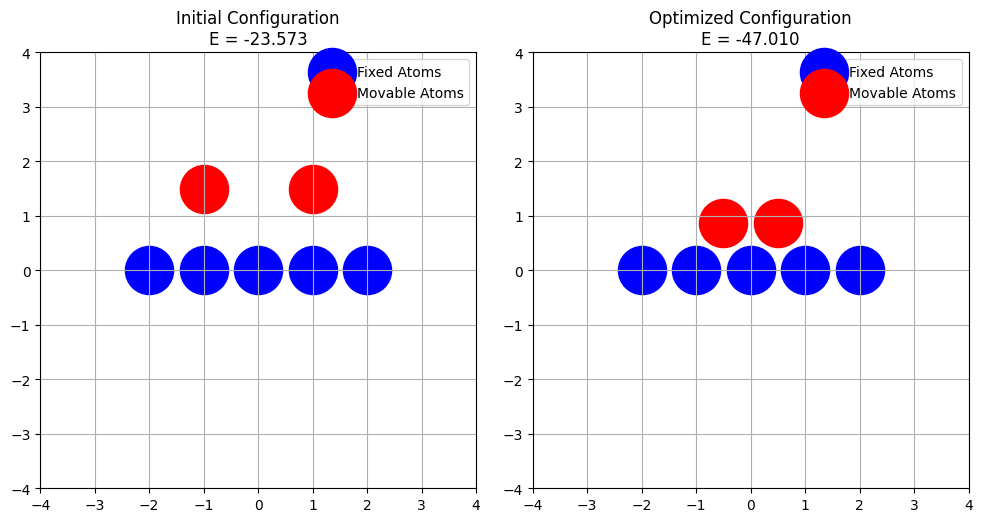

[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 2.          0.        ]
 [-1.          0.        ]
 [-2.          0.        ]
 [ 0.49993296  0.86373766]
 [-0.49992189  0.86373777]]


In [188]:


# Lennard-Jones potential object
lj = LennardJones()

# Create and run the ClusterOptimizer
optimizer = ClusterOptimizer(
    potential=lj,
    num_movable=2,
    tolerance=1e-5,
    max_iters=2000,
)

fixed_atoms, movable_atoms, final_positions = optimizer.run_optimization()

plotter = AtomicClusterPlotter(
    potential=lj,
    fixed_atoms=fixed_atoms,
    movable_atoms=movable_atoms,  
    final_positions=final_positions,
)

plotter.plot_init_final()
print(final_positions)



Now we know (using Metropolis MC optimization from w3) where the equilibrium position is.

In the next part we will displace the atoms slightly, and then run moledyn sim.

### 6.3 Molecular dynamics

Displace the atoms slightly from their equilibrium positions. Perform a constant energy molecular dynamics simulation, i.e.:

- propagate the atoms according to the velocity Verlet algo. Use $\Delta t= 0.01$.

Note that in a constant energy molecular dynamics simulation, no thermostat is used.
Observe that the atoms vibrate around their equilibrium positions. Check that the total energy is conserved.

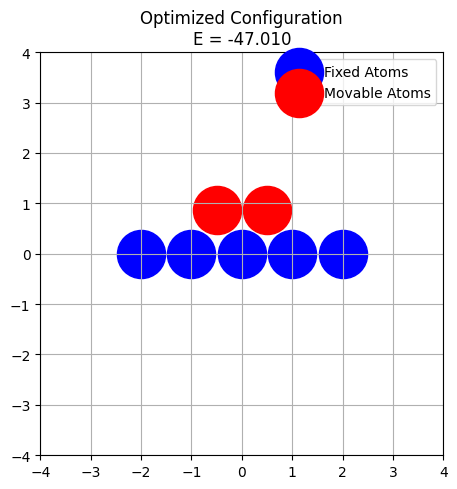

In [ ]:
equilibrium = final_positions




### 6.4 Animation

Make an animation of the molecular dynamics simulation.

## Exercise 27

### 7.1 Constant Temperature MD in 6D

a) Perform molecular dynamics simulations for a 3-atomic Lennard-Jones cluster in two dimensions.

Hint:

- start in the equilibrium state
- perform 50 velocity Verlet timesteps with $\Delta t = 0.01.
- apply the thermostat (use the few-atom one that simply draws velocity components from a Normal distribution)
- store the total energy for later inspection
- repeat 1000 times

### 7.2 Inspect energy versus temperature

The total energies collected during the simulation shows convergence toward some different values depending on the temperatures. If the simulation has run long enough, the thermal average of the total energy can be obtained as a mean value over the last observations.

b) Plot the thermally averaged total energy as a function of temperature.

c) Find $C_v$ at temperature $T_{I,I+1}=½(T_i+T_{i+1})$ via:
$$ C_v=(T_{i,i+1} )=\frac{\langle E \rangle_{T_{i+1}}-\langle E \rangle_{T_i}}{T_{i+1}-T_i} $$

Observe that before evaporation, you have a behavior of $C_v$ corresponding to having 9 degrees of freedom with squared terms (with non-zero coefficients) in the energy, while after the evaporation, you have 6 such degrees of freedom.

## Exercise 28

### 8.1 Constant Temperature MD in many-D

In this exercise, you will perform constant temperature MD in many dimensions. The purpose of the exercise is to show the importance of the starting configuration. If you start very far from the global minimum energy structure, you might miss that region in configuration space and rather get a thermal equilibrium around a meta-stable state.

This is very akin to daily life, where matter is not always found in the ground state. Graphite is more stable than diamond at ambient pressures, yet, if diamond was formed (under high pressure) it may remain in its meta-stable state, and it may be of relevance to model its properties (e.g. heat capacity and vibrational modes).

Simialarly, snowflakes (of a given size) come in many shapes, reflecting the kinetic details of how they were formed. Yet, only one snowflake can be considered the most stable, and most likely, it is a dull one where the constituing water molecules have rolled up in a sphere.

If you perform a molecular dynamics simulation starting in a meta-stable state, it may take while before the expected transitions happen, and rather the simulation may equilibrate around the meta-stable state.

The exercise ends with applying simulated annealing, which aims at finding the global minimum energy structure.

### 8.2 Initial states

a) Setup a system of a large number of particles contained in 2D inside a corral of static atoms. Feel free to choose your own shape for the corral (circular, elliptic, quadratic, rectangular, rhombic?). Follow two strategies, where the atoms are either placed ordered along the corral or at random in the middle of the corral. Relax the two structures to obtain two types of starting configurations for the next exercises.

### 8.3 Heating up
b) Perform the MD at increasing temperatures for the two types of starting configurations: